In [7]:
import os
import numpy as np
from custom_datagen import imageLoader
# import tensorflow as tf
import tensorflow.keras
from matplotlib import pyplot as plt
import glob
import random
from tqdm import tqdm

In [4]:
import yaml
yfile = open("../settings2.yaml")
hp = yaml.load(yfile,Loader=yaml.FullLoader)

SplitDataPath = hp.get("BraTS2020").get("SplitDataPath")
train_img_dir = os.path.join(SplitDataPath,"train","images","")
train_mask_dir = os.path.join(SplitDataPath,"train","masks","")

val_img_dir = os.path.join(SplitDataPath,"val","images","")
val_mask_dir = os.path.join(SplitDataPath,"val","masks","")

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [9]:
#############################################################
# Optional step of finding the distribution of each class and calculating appropriate weights
# Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd

columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob(os.path.join(train_mask_dir,"*.npy")))
for img in tqdm(range(len(train_mask_list))):
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
# Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels / (n_classes * label_0)), 2)  # round to 2 decimals
wt1 = round((total_labels / (n_classes * label_1)), 2)
wt2 = round((total_labels / (n_classes * label_2)), 2)
wt3 = round((total_labels / (n_classes * label_3)), 2)

# Weights are: 0.26, 22.53, 22.53, 26.21
# wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
# These weihts can be used for Dice loss

100%|██████████| 258/258 [00:07<00:00, 34.22it/s]


In [3]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                              val_mask_dir, val_mask_list, batch_size)

In [4]:
# test the generator
img, msk = train_img_datagen.__next__()

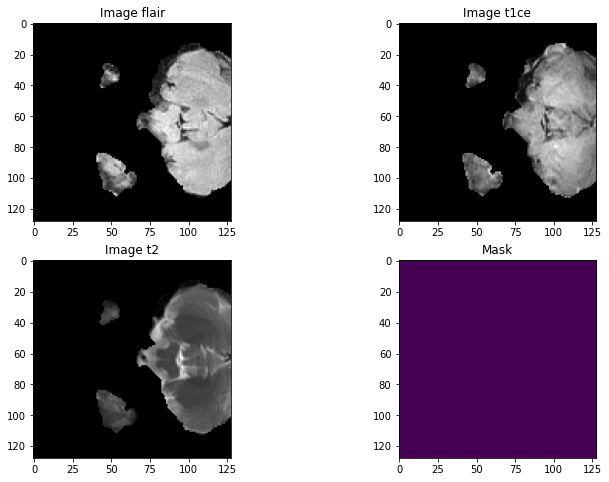

In [5]:
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()

In [6]:
# Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
import segmentation_models_3D as sm
import tensorflow as tf
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [7]:
# Fit the model

steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

from simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)


2021-12-07 00:03:43.561087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:43.565494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:43.565916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:43.566438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [10]:

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=2,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    )

model.save('./models/brats_3d.hdf5')

Epoch 1/2
129/129 [==============================] - 77s 594ms/step - loss: 0.9420 - accuracy: 0.9518 - iou_score: 0.2347 - val_loss: 0.9431 - val_accuracy: 0.9503 - val_iou_score: 0.2221
Epoch 2/2
129/129 [==============================] - 77s 598ms/step - loss: 0.9412 - accuracy: 0.9519 - iou_score: 0.2338 - val_loss: 0.9427 - val_accuracy: 0.9503 - val_iou_score: 0.2194


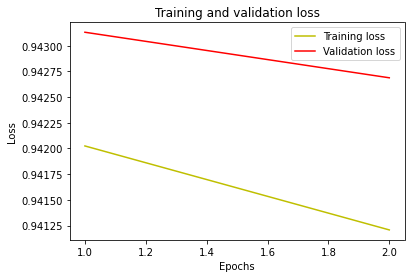

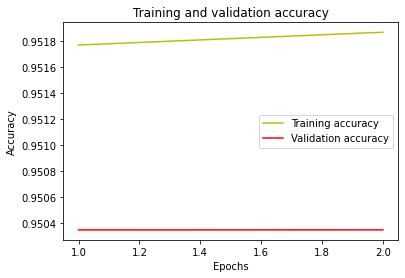

In [11]:
# plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

# Load model for prediction or continue training
save_model_path = './models/new_model.hdf5'
my_model = load_model(save_model_path,
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# Now all set to continue the training process.
history2 = my_model.fit(train_img_datagen,
                        steps_per_epoch=steps_per_epoch,
                        epochs=1,
                        verbose=1,
                        validation_data=val_img_datagen,
                        validation_steps=val_steps_per_epoch,
                        )
my_model.save('./models/continue_model.hdf5')

2021-12-07 00:32:45.208740: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Mean IoU = 0.23390904


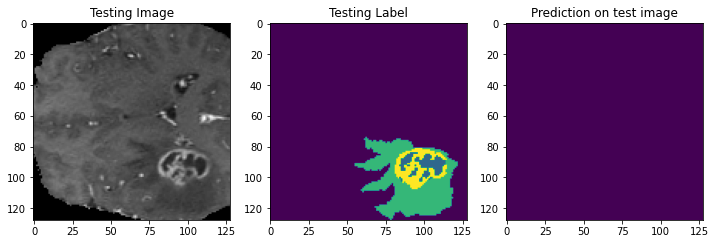

In [13]:
# For predictions you do not need to compile the model, so ...
from keras.models import load_model
my_model = load_model('./models/brats_3d.hdf5',
                      compile=False)

# Verify IoU on a batch of images from the test dataset
# Using built in keras function for IoU
# Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size = 8  # Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                               val_mask_dir, val_mask_list, batch_size)

# Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
# Predict on a few test images, one at a time
# Try images:
img_num = 82

test_img = np.load(os.path.join(val_img_dir,"image_" + str(img_num) + ".npy"))
test_mask = np.load(os.path.join(val_mask_dir,"mask_" + str(img_num) + ".npy"))
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]

# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


# Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

# n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:, :, n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:, :, n_slice])
plt.show()